# This is a notebook implementing Danish BERT for NER classification on the DaNE dataset

In [1]:
!pip install danlp


[notice] A new release of pip available: 22.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Loading packages
## Standard packages
import os

import math

import pandas as pd

import numpy as np

## pyTorch
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

## Transformers
from transformers import BertTokenizer, AutoTokenizer
from transformers import BertForTokenClassification, AutoModelForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

## Other ML utils
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences


from tqdm import tqdm,trange

from danlp.datasets import DDT


In [3]:
os.chdir("./../../../../data")
os.getcwd()

'/home/jovyan/work/danish/-l-ctra/data'

## Loading and inspecting data

In [4]:
# Load the DaNE data
train, val, test = DDT().load_as_simple_ner(predefined_splits=True)

# Split sentences and labels
tr_sentences, tr_labels = train
val_sentences, val_labels = val
test_sentences, test_labels = test

In [5]:
def is_misc(ent: str):
    if len(ent) < 4:
        return False
    return ent[-4:] == 'MISC'


def remove_miscs(se: list):
    return [
        [entity if not is_misc(entity) else 'O' for entity in entities]
        for entities in se
    ]

In [6]:
# Replace MISC with O for fair comparisons
tr_labels = remove_miscs(tr_labels)
val_labels = remove_miscs(val_labels)
test_labels = remove_miscs(test_labels)

In [7]:
#Sanity checking number of words
print(len(tr_labels))
print(len(val_labels))
print(len(test_labels))

4383
564
565


The ELECTRA model requires input data to be in a specific format. One requirement is to have special tokens that marks the beginning ([CLS]) and the separation/end of sentences ([SEP]). These tokens are added to the list of label values below. Furthermore, the label [PAD] is added to indicate padded tokens after padding the sentences later in the process.

In [8]:
# Adding labels to fine-tune the BERT
tag_values = ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG']  #list(set(labels for list in tr_labels for labels in list))
tag_values.append("[PAD]")
tag_values.append("[CLS]")
tag_values.append("[SEP]")
print(tag_values)

#Creating tag to index and index to tags variables
tag2idx = {t: i for i, t in enumerate(tag_values)}
idx2tag = {i: t for t, i in tag2idx.items()}
print(tag2idx)
print(idx2tag)

['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG', '[PAD]', '[CLS]', '[SEP]']
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-LOC': 3, 'I-LOC': 4, 'B-ORG': 5, 'I-ORG': 6, '[PAD]': 7, '[CLS]': 8, '[SEP]': 9}
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-LOC', 4: 'I-LOC', 5: 'B-ORG', 6: 'I-ORG', 7: '[PAD]', 8: '[CLS]', 9: '[SEP]'}


## Making the training data using the vocabulary from multilingual BERT

In [9]:
# Checking whether GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 


'NVIDIA RTX A4000'

BERT provides its own tokenizer which is imported below. The tokenizer is created with a Wordpiece model and it creates a vocabulary of whole words, subwords and individual characters.

In [10]:
# load tokenizer, with manual file address or pretrained address from the Transformers library
# where is this file?
# https://www.dropbox.com/s/19cjaoqvv2jicq9/danish_bert_uncased_v2.zip?dl=1
tokenizer = BertTokenizer.from_pretrained("danish_bert_uncased_v2/vocab.txt", do_lower_case = True, strip_accents = False)

/opt/conda/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1656: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


In [11]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [12]:
tr_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(s, l)
    for s, l in zip(tr_sentences, tr_labels)
]

val_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(s, l)
    for s, l in zip(val_sentences, val_labels)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(s, l)
    for s, l in zip(test_sentences, test_labels)
]



In [13]:
tr_tokenized_texts_and_labels[0]

(['på',
  'fredag',
  'har',
  'sid',
  'inviteret',
  'til',
  'reception',
  'i',
  'sid',
  '-',
  'huset',
  'i',
  'anledning',
  'af',
  'at',
  'formanden',
  'kjeld',
  'christensen',
  'går',
  'ind',
  'i',
  'de',
  'glade',
  'tre',
  '##sser',
  '##e',
  '.'],
 ['O',
  'O',
  'O',
  'B-ORG',
  'O',
  'O',
  'O',
  'O',
  'B-LOC',
  'B-LOC',
  'B-LOC',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-PER',
  'I-PER',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [14]:
tr_tokenized_texts = [["[CLS]"] + tr_token_label_pair[0] + ["[SEP]"] for tr_token_label_pair in tr_tokenized_texts_and_labels]
tr_labels = [["[CLS]"] + tr_token_label_pair[1] + ["[SEP]"] for tr_token_label_pair in tr_tokenized_texts_and_labels]


val_tokenized_texts = [["[CLS]"] + val_token_label_pair[0] + ["[SEP]"] for val_token_label_pair in val_tokenized_texts_and_labels]
val_labels = [["[CLS]"] + val_token_label_pair[1] + ["[SEP]"] for val_token_label_pair in val_tokenized_texts_and_labels]
 

test_tokenized_texts = [["[CLS]"] + test_token_label_pair[0] + ["[SEP]"] for test_token_label_pair in test_tokenized_texts_and_labels]
test_labels = [["[CLS]"] + test_token_label_pair[1] + ["[SEP]"] for test_token_label_pair in test_tokenized_texts_and_labels]

#Example of word-piece tokenizations:
print(tr_tokenized_texts[0])
print(tr_labels[0])

['[CLS]', 'på', 'fredag', 'har', 'sid', 'inviteret', 'til', 'reception', 'i', 'sid', '-', 'huset', 'i', 'anledning', 'af', 'at', 'formanden', 'kjeld', 'christensen', 'går', 'ind', 'i', 'de', 'glade', 'tre', '##sser', '##e', '.', '[SEP]']
['[CLS]', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[SEP]']


Note that number of words in all datasets are increased due to the word-piece tokenization. For the test dataset this means that it will have a higher number of words i.e. labels also during evaluation and comparison to the rule-based classification

In [15]:
#number of words increased from 7,416 to 22,424
tmp=0
for labels in test_labels:
    tmp=tmp+len(labels)
tmp

13017

In [16]:
# Len of the sentence must be not bigger than the training model
# See model's 'max_position_embeddings' = 512

MAX_LEN = 128# len(max(tr_tokenized_texts, key = len))
print(MAX_LEN)
bs = 32

128


Indexing tokens in sentences

In [17]:
tr_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tr_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

#Example of indexing
print(tr_input_ids[0])

[    2    58  3314    87   456  7898    45 13801    23   456   105  2486
    23  4872    47    39  6123 17059  6244   564   164    23    69  3806
   862  7113 31694   771     3     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Indexing labels

In [18]:
tr_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in tr_labels],
                     maxlen=MAX_LEN, value=tag2idx["[PAD]"], padding="post",
                     dtype="long", truncating="post")


val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag2idx["[PAD]"], padding="post",
                     dtype="long", truncating="post")


test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["[PAD]"], padding="post",
                     dtype="long", truncating="post")

#Example of indexing
print(tr_tags[10])


[8 1 2 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


Creating attention masks that indicates which elements in the sentence are tokens and which are padding elements. So here we create the mask to ignore the padded elements in the sequences.

In [19]:
tr_attention_masks = [[float(i != 0) for i in ii] for ii in tr_input_ids]


val_attention_masks = [[float(i != 0) for i in ii] for ii in val_input_ids]

test_attention_masks = [[float(i != 0) for i in ii] for ii in test_input_ids]

#Example of attention masks
print(tr_attention_masks[10])


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Pytorch requires converting datasets into torch tensors (multidimensional matrices). Inputs, tags and mask ID's for training and test data are converted to tensors and moved to the GPU by applying .to(device)

In [20]:
tr_inputs = torch.tensor(tr_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)

tr_masks = torch.tensor(tr_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)


Creating training and test tensor datasets and defining data loaders. Shuffling the training data with RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [21]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

## Train model

We load the pre-trained bert-base-cased model and provide the number of possible labels.

In [23]:
pt_model_dir = "danish_bert_uncased_v2"

# Will load config and weight with from_pretrained(). 
model = BertForTokenClassification.from_pretrained(pt_model_dir, num_labels=len(tag2idx), output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at danish_bert_uncased_v2 were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized fro

In [24]:
# Set model to GPU,if you are using GPU machine
model.cuda();

In [25]:
print(f'Number of trainable parameters: {model.num_parameters()}')

Number of trainable parameters: 110034442


Setting full finetuning to true because we have capacity to fine tune all layers / update all weights. Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.

In [26]:
pad_tok = tokenizer.vocab["[PAD]"]
sep_tok = tokenizer.vocab["[SEP]"]
cls_tok = tokenizer.vocab["[CLS]"]

In [27]:
def flat_accuracy(valid_tags, pred_tags):

    """
    Define a flat accuracy metric to use while training the model.
    """

    return (np.array(valid_tags) == np.array(pred_tags)).mean()

In [28]:
def annot_confusion_matrix(valid_tags, pred_tags):

    """
    Create an annotated confusion matrix by adding label
    annotations and formatting to sklearn's `confusion_matrix`.
    """

    # Create header from unique tags
    header = sorted(list(set(valid_tags + pred_tags)))

    # Calculate the actual confusion matrix
    matrix = confusion_matrix(valid_tags, pred_tags, labels = ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG'])

    # Final formatting touches for the string output
    mat_formatted = [header[i] + "\t" + str(row) for i, row in enumerate(matrix)]
    content = "\t" + " ".join(header) + "\n" + "\n".join(mat_formatted)

    return content

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,        
    lr=3e-5 #The authors of BERT uses 3e-5 as lr for BERT-base
    )

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
epochs = 4 # Train a maximum of 3-4 epochs. More will simply result in overfitting the training data. 
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    
    num_training_steps=total_steps
)

In [31]:
epoch = 0

torch.manual_seed(1)
np.random.seed(1)

tr_loss_values, eval_loss_values = [], []
for _ in trange(epochs, desc="Epoch"):
    epoch += 1

    # Training loop
    print("\nStarting training loop.")
    model.train()
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []

    for step, batch in enumerate(train_dataloader):

        # Add batch to gpu
        batch = tuple(t.to(torch.int64).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Forward pass
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )
        loss, tr_logits = outputs[:2]

        # Backward pass
        loss.backward()

        # Compute train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        # Subset out unwanted predictions on CLS/PAD/SEP tokens
        preds_mask = (
            (b_input_ids != cls_tok)
            & (b_input_ids != pad_tok)
            & (b_input_ids != sep_tok)
        )

        #preds_mask = preds_mask.detach().cpu().numpy()
        tr_logits = tr_logits.detach().cpu().numpy()
        tr_label_ids = torch.masked_select(b_labels, (preds_mask == 1))
        tr_batch_preds = np.argmax(tr_logits[preds_mask.detach().cpu().numpy().squeeze()], axis=1)
        tr_batch_labels = tr_label_ids.to("cpu").numpy()
        tr_preds.extend(tr_batch_preds)
        tr_labels.extend(tr_batch_labels)

        # Compute training accuracy
        tmp_tr_accuracy = flat_accuracy(tr_batch_labels, tr_batch_preds)
        tr_accuracy += tmp_tr_accuracy

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=max_grad_norm
        )

        # Update parameters
        optimizer.step()
        model.zero_grad()

    tr_loss = tr_loss / nb_tr_steps
    tr_loss_values.append(tr_loss)
    tr_accuracy = tr_accuracy / nb_tr_steps

    # Print training loss and accuracy per epoch
    print(f"Train loss: {tr_loss}")
    print(f"Train accuracy: {tr_accuracy}")

    # Validation loop
    print("Starting validation loop.")

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions, true_labels = [], []

    for batch in valid_dataloader:

        batch = tuple(t.to(torch.int64).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            tmp_eval_loss, logits = outputs[:2]

        # Subset out unwanted predictions on CLS/PAD/SEP tokens
        preds_mask = (
            (b_input_ids != cls_tok)
            & (b_input_ids != pad_tok)
            & (b_input_ids != sep_tok)
        )

        logits = logits.to("cpu").numpy()
        label_ids = torch.masked_select(b_labels, (preds_mask == 1))
        val_batch_preds = np.argmax(logits[preds_mask.detach().cpu().numpy().squeeze()], axis=1)
        val_batch_labels = label_ids.to("cpu").numpy()
        predictions.extend(val_batch_preds)
        true_labels.extend(val_batch_labels)

        tmp_eval_accuracy = flat_accuracy(val_batch_labels, val_batch_preds)

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy


        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    # Evaluate loss, acc, conf. matrix, and class. report on validation set
    pred_tags = [idx2tag[i] for i in predictions]
    valid_tags = [idx2tag[i] for i in true_labels]
    cl_report = classification_report(valid_tags, pred_tags)
    conf_mat = annot_confusion_matrix(valid_tags, pred_tags)
    eval_loss = eval_loss / nb_eval_steps
    eval_loss_values.append(eval_loss)
    eval_accuracy = eval_accuracy / nb_eval_steps
    f1score = f1_score(valid_tags, pred_tags, labels = ['B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG'], average="micro")

    # Report metrics
    print(f"Validation loss: {eval_loss}\n")
    print(f"Validation Accuracy: {eval_accuracy}\n")
    print(f"F1-Score: {f1score}\n")
    print(f"Classification Report:\n {cl_report}")
    print(f"Confusion Matrix:\n {conf_mat}")

Epoch:   0% 0/4 [00:00<?, ?it/s]


Starting training loop.
Train loss: 0.18414084083081161
Train accuracy: 0.8265796762945476
Starting validation loop.


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1

Validation loss: 0.052569341328408986

Validation Accuracy: 0.9705475370691903

F1-Score: 0.7323146576117714

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.63      0.77      0.70       188
       B-ORG       0.68      0.51      0.58       197
       B-PER       0.85      0.82      0.84       251
       I-LOC       0.00      0.00      0.00        21
       I-ORG       0.69      0.14      0.23        64
       I-PER       0.88      0.93      0.90       201
           O       0.99      0.99      0.99     11273
       [PAD]       0.00      0.00      0.00         0

    accuracy                           0.97     12195
   macro avg       0.59      0.52      0.53     12195
weighted avg       0.97      0.97      0.97     12195

Confusion Matrix:
 	B-LOC B-ORG B-PER I-LOC I-ORG I-PER O [PAD]
B-LOC	[207  12  10   0   2   0]
B-ORG	[  9 186   2   0   0   0]
B-PER	[  2   0 145   0   6   0]
I-LOC	[ 0  0 15  0  2  1]
I-ORG	[ 12   0  22   0 100   

Epoch:  50% 2/4 [00:55<00:55, 27.72s/it]

Validation loss: 0.03748501568204827

Validation Accuracy: 0.9789213830099768

F1-Score: 0.8146157979580871

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.75      0.89      0.81       188
       B-ORG       0.73      0.69      0.71       197
       B-PER       0.88      0.91      0.90       251
       I-LOC       0.50      0.14      0.22        21
       I-ORG       0.57      0.62      0.60        64
       I-PER       0.93      0.92      0.92       201
           O       0.99      0.99      0.99     11273

    accuracy                           0.98     12195
   macro avg       0.77      0.74      0.74     12195
weighted avg       0.98      0.98      0.98     12195

Confusion Matrix:
 	B-LOC B-ORG B-PER I-LOC I-ORG I-PER O
B-LOC	[229   5   2   0   4   0]
B-ORG	[ 14 184   0   0   2   1]
B-PER	[  0   0 167   1   9   1]
I-LOC	[ 0  0 13  3  1  4]
I-ORG	[  4   0  16   0 135   6]
I-PER	[ 0  1  6  2  7 40]

Starting training loop.
Train l

Epoch:  75% 3/4 [01:23<00:27, 27.66s/it]

Validation loss: 0.038866938919656806

Validation Accuracy: 0.9815739398769429

F1-Score: 0.8399781540141997

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.83      0.89      0.86       188
       B-ORG       0.78      0.71      0.74       197
       B-PER       0.90      0.91      0.91       251
       I-LOC       0.62      0.38      0.47        21
       I-ORG       0.60      0.67      0.63        64
       I-PER       0.95      0.92      0.93       201
           O       0.99      0.99      0.99     11273

    accuracy                           0.98     12195
   macro avg       0.81      0.78      0.79     12195
weighted avg       0.98      0.98      0.98     12195

Confusion Matrix:
 	B-LOC B-ORG B-PER I-LOC I-ORG I-PER O
B-LOC	[228   2   2   0   2   0]
B-ORG	[ 15 184   0   0   0   1]
B-PER	[  0   0 167   1  10   0]
I-LOC	[0 0 7 8 2 3]
I-ORG	[  1   0  11   0 139   2]
I-PER	[ 0  1  5  4  4 43]

Starting training loop.
Train loss: 

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100% 4/4 [01:50<00:00, 27.68s/it]

Validation loss: 0.03695434404330121

Validation Accuracy: 0.9826229861430795

F1-Score: 0.8502415458937198

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.86      0.88      0.87       188
       B-ORG       0.76      0.78      0.77       197
       B-PER       0.94      0.90      0.92       251
       I-LOC       0.40      0.67      0.50        21
       I-ORG       0.61      0.69      0.65        64
       I-PER       0.94      0.94      0.94       201
           O       0.99      0.99      0.99     11273
       [PAD]       0.00      0.00      0.00         0

    accuracy                           0.98     12195
   macro avg       0.69      0.73      0.71     12195
weighted avg       0.98      0.98      0.98     12195

Confusion Matrix:
 	B-LOC B-ORG B-PER I-LOC I-ORG I-PER O [PAD]
B-LOC	[227   3   2   0   5   0]
B-ORG	[  9 189   0   0   0   3]
B-PER	[  0   0 165   8  11   0]
I-LOC	[ 0  0  2 14  0  5]
I-ORG	[  1   0  10   0 153   1

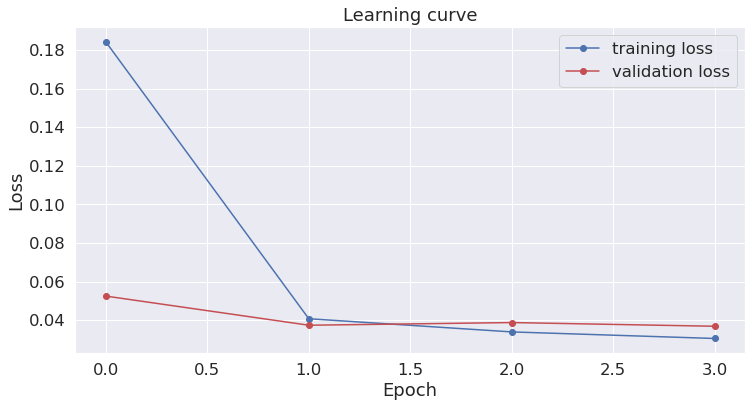

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(tr_loss_values, 'b-o', label="training loss")
plt.plot(eval_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [33]:
ner_model_path = 'research/daNLP/NER/models/Danish_BERT'

In [34]:
# Make dir if not exits
if not os.path.exists(ner_model_path):
        os.makedirs(ner_model_path)

In [35]:
# Saving the model and the tokenizer

model_to_save = model.module if hasattr(model, 'module') else model #Take care of distrubuted/parallel training
model_to_save.save_pretrained(ner_model_path)
tokenizer.save_pretrained(ner_model_path)

('research/daNLP/NER/models/Danish_BERT/tokenizer_config.json',
 'research/daNLP/NER/models/Danish_BERT/special_tokens_map.json',
 'research/daNLP/NER/models/Danish_BERT/vocab.txt',
 'research/daNLP/NER/models/Danish_BERT/added_tokens.json')

In [36]:
# Loading the model to tokenize the test sentece
model = BertForTokenClassification.from_pretrained(ner_model_path)
tokenizer = BertTokenizer.from_pretrained(ner_model_path, do_lower_case = True, strip_accents = False)

In [37]:
model.cuda();

In [38]:
pad_tok = tokenizer.vocab["[PAD]"]
sep_tok = tokenizer.vocab["[SEP]"]
cls_tok = tokenizer.vocab["[CLS]"]

torch.manual_seed(1)
np.random.seed(1)

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
predictions, true_labels = [], []
tr_loss_values, test_loss_values = [], []

for batch in test_dataloader:

    batch = tuple(t.to(torch.int64).to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
        )
        tmp_test_loss, logits = outputs[:2]

    # Subset out unwanted predictions on CLS/PAD/SEP tokens
    preds_mask = (
        (b_input_ids != cls_tok)
        & (b_input_ids != pad_tok)
        & (b_input_ids != sep_tok)
    )

    logits = logits.to("cpu").numpy()
    label_ids = torch.masked_select(b_labels, (preds_mask == 1))
    test_batch_preds = np.argmax(logits[preds_mask.detach().cpu().numpy().squeeze()], axis=1)
    test_batch_labels = label_ids.to("cpu").numpy()
    predictions.extend(test_batch_preds)
    true_labels.extend(test_batch_labels)

    tmp_test_accuracy = flat_accuracy(test_batch_labels, test_batch_preds)

    test_loss += tmp_test_loss.mean().item()
    test_accuracy += tmp_test_accuracy


    nb_test_examples += b_input_ids.size(0)
    nb_test_steps += 1

# Evaluate loss, acc, conf. matrix, and class. report on devset
pred_tags = [idx2tag[i] for i in predictions]
valid_tags = [idx2tag[i] for i in true_labels]
cl_report = classification_report(valid_tags, pred_tags, labels = ['B-LOC', 'B-PER', 'I-LOC', 'I-PER', 'B-ORG', 'I-ORG'])
conf_mat = annot_confusion_matrix(valid_tags, pred_tags)
test_loss = test_loss / nb_test_steps
test_loss_values.append(test_loss)
test_accuracy = test_accuracy / nb_test_steps
f1score_micro = f1_score(valid_tags, pred_tags, labels = ['B-LOC', 'B-PER', 'I-LOC', 'I-PER', 'B-ORG', 'I-ORG'], average="micro")
f1score_macro = f1_score(valid_tags, pred_tags, labels = ['B-LOC', 'B-PER', 'I-LOC', 'I-PER', 'B-ORG', 'I-ORG'], average="macro")


# Report metrics
print(f"Number of Epochs: {epochs}\n")

print(f"Test loss: {test_loss}\n")
print(f"Test Accuracy: {test_accuracy}\n")

print(f"F1-Score Micro: {f1score_micro}\n")
print(f"F1-Score Macro: {f1score_macro}\n")

print(f"Classification Report:\n {cl_report}")
print(f"Confusion Matrix:\n {conf_mat}")

with open(f'{ner_model_path}/TESTMETRICS','a+') as f:
    f.write(f"Number of Epochs: {epochs}\n")

    f.write(f"Test loss: {test_loss}\n")
    f.write(f"Test Accuracy: {test_accuracy}\n")

    f.write(f"F1-Score Micro: {f1score_micro}\n")
    f.write(f"F1-Score Macro: {f1score_macro}\n")

    f.write(f"Classification Report:\n {cl_report}")
    f.write(f"Confusion Matrix:\n {conf_mat}")



Number of Epochs: 4

Test loss: 0.041447424019376435

Test Accuracy: 0.9773173648600353

F1-Score Micro: 0.8301382077574676

F1-Score Macro: 0.738112888238303

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.81      0.87      0.83       172
       B-PER       0.87      0.91      0.89       274
       I-LOC       0.21      0.88      0.34         8
       I-PER       0.96      1.00      0.98       260
       B-ORG       0.81      0.64      0.71       333
       I-ORG       0.79      0.57      0.67        94

   micro avg       0.84      0.82      0.83      1141
   macro avg       0.74      0.81      0.74      1141
weighted avg       0.85      0.82      0.83      1141

Confusion Matrix:
 	B-LOC B-ORG B-PER I-LOC I-ORG I-PER O
B-LOC	[249   3   0   0   2   0]
B-ORG	[  0 260   0   0   0   0]
B-PER	[  0   0 149   4   1   0]
I-LOC	[0 0 1 7 0 0]
I-ORG	[ 30   0  28   4 212   4]
I-PER	[ 0  6  1 16  6 54]


# Testing the model's capabilities on specific tokens only

In [39]:
#test["labels"][test["labels"].str.contains("PER")]="B-PER"
valid_tags = pd.Series(valid_tags)
valid_tags[valid_tags.str.contains("PER")] = "B-PER"
valid_tags[valid_tags.str.contains("LOC")] = "B-LOC"
valid_tags = valid_tags.tolist()

pred_tags = pd.Series(pred_tags)
pred_tags[pred_tags.str.contains("PER")] = "B-PER"
pred_tags[pred_tags.str.contains("LOC")] = "B-LOC"
pred_tags = pred_tags.tolist()

In [40]:
cl_report = classification_report(valid_tags, pred_tags, labels = ['B-LOC', 'B-PER'])
conf_mat = confusion_matrix(valid_tags, pred_tags)
f1score = f1_score(valid_tags, pred_tags, labels = ['B-LOC', 'B-PER'], average = "macro")

# Report metrics
print(f"F1-Score: {f1score}\n")
print(f"Classification Report:\n {cl_report}")
print(f"Confusion Matrix:\n {conf_mat}")

F1-Score: 0.8746787195850696

Classification Report:
               precision    recall  f1-score   support

       B-LOC       0.74      0.89      0.81       180
       B-PER       0.92      0.96      0.94       534

   micro avg       0.87      0.94      0.91       714
   macro avg       0.83      0.93      0.87       714
weighted avg       0.88      0.94      0.91       714

Confusion Matrix:
 [[  161     1     0     0    18]
 [   32   212    30     4    55]
 [    0     2   512     0    20]
 [   17     6     6    54    11]
 [    8    40     7    10 10681]]


In [41]:
test_sentence = "Indkøb af Melon 1 kg, 2 slags Karen Volf 200g, 2 poser Chili og Timian fra Santa Maria, Arla 1L. Vores referencer: Karen Volf, Chili Jensen, Timian Hansen og Arla Kristoffersen. Kontaktperson er Melon Andersen. Levering til Timianvej 12"
test_sentence2 = "Timian Nielsen har bestilt 10 kasser Lego til levering på Hc. Andersensvej 13 A første Sal tv og han har købt det til sin datter chili som går med Åben ble fra Abena og hun elsker i øvrigt elsker at spise chili, så derfor har de 10 kg chili derhjemme, men hvad chili ikke ved er at hendes far har købt en hvid 3 hjulet cykel fra Toys R Us ved Toppen Nr. 3 Aarhus- helt specifikt er det en 3 hjulet nr 30 fra kataloget og han har husket Toppen beskyttelseshjelm, str 35 og Far Timian kan godt lide chiLi men han elsker at spise en Tivoli stang, derfor bestilte han 20 stk Toms tivoli stang så han kan dele med sin ven Sebsatian i stedet for at få Melon i Grøn Box."

In [42]:
tokenized_sentence = tokenizer.encode(test_sentence)
print(tokenized_sentence)

[2, 3509, 47, 467, 53, 127, 3219, 911, 148, 2009, 8385, 1974, 31708, 808, 31703, 911, 148, 16894, 12390, 28, 28254, 145, 18482, 6357, 911, 26370, 127, 31702, 771, 339, 14209, 1325, 8385, 1974, 31708, 911, 12390, 3683, 911, 28254, 3744, 28, 26370, 26460, 134, 771, 12841, 33, 467, 53, 4459, 771, 4457, 45, 28254, 578, 1082, 3]


In [43]:
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [44]:
with torch.no_grad():
    logits = model(input_ids)
logits = F.softmax(logits[0], dim = 2)
logits_label = torch.argmax(logits, dim = 2)
logits_label = logits_label.detach().cpu().numpy().tolist()[0]

logits_confidence = [values[label].item() for values, label in zip(logits[0], logits_label)]
len(logits_confidence)

58

In [45]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels, new_probs = [], [], []
for token, label_idx, probs in zip(tokens, logits_label, logits_confidence):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
        new_probs.append(probs)

In [46]:
for token, label, prob in zip(new_tokens, new_labels, new_probs):
    print("{}\t{}\t{}".format(label, token, prob))


[SEP]	[CLS]	0.35406693816185
O	indkøb	0.9997159838676453
O	af	0.9997386336326599
O	melon	0.7387145757675171
O	1	0.9984843134880066
O	kg	0.9990200996398926
O	,	0.9997584223747253
O	2	0.9996015429496765
O	slags	0.9996067881584167
B-PER	karen	0.9913374185562134
I-PER	volf	0.9940366744995117
O	200g	0.9955313801765442
O	,	0.9997616410255432
O	2	0.9997190833091736
O	poser	0.9996324777603149
O	chili	0.8727623820304871
O	og	0.9984689354896545
O	timian	0.9261709451675415
O	fra	0.9994376301765442
B-ORG	santa	0.6258220672607422
I-ORG	maria	0.49883905053138733
O	,	0.9965651631355286
B-ORG	arla	0.5763012766838074
I-LOC	1l	0.5286656022071838
O	.	0.999380350112915
O	vores	0.999336302280426
O	referencer	0.9991549253463745
O	:	0.9996308088302612
B-PER	karen	0.9944873452186584
I-PER	volf	0.9955767393112183
O	,	0.99953293800354
B-PER	chili	0.994709849357605
I-PER	jensen	0.9945797920227051
O	,	0.999550998210907
B-PER	timian	0.992206871509552
I-PER	hansen	0.9924864768981934
O	og	0.9996300935745239
B-PER	ar

In [47]:
dict_predictions = [{"Word":token,"Label":label,"Confidence":prob} for token, label, prob in zip(new_tokens, new_labels, new_probs)]
dict_predictions

[{'Word': '[CLS]', 'Label': '[SEP]', 'Confidence': 0.35406693816185},
 {'Word': 'indkøb', 'Label': 'O', 'Confidence': 0.9997159838676453},
 {'Word': 'af', 'Label': 'O', 'Confidence': 0.9997386336326599},
 {'Word': 'melon', 'Label': 'O', 'Confidence': 0.7387145757675171},
 {'Word': '1', 'Label': 'O', 'Confidence': 0.9984843134880066},
 {'Word': 'kg', 'Label': 'O', 'Confidence': 0.9990200996398926},
 {'Word': ',', 'Label': 'O', 'Confidence': 0.9997584223747253},
 {'Word': '2', 'Label': 'O', 'Confidence': 0.9996015429496765},
 {'Word': 'slags', 'Label': 'O', 'Confidence': 0.9996067881584167},
 {'Word': 'karen', 'Label': 'B-PER', 'Confidence': 0.9913374185562134},
 {'Word': 'volf', 'Label': 'I-PER', 'Confidence': 0.9940366744995117},
 {'Word': '200g', 'Label': 'O', 'Confidence': 0.9955313801765442},
 {'Word': ',', 'Label': 'O', 'Confidence': 0.9997616410255432},
 {'Word': '2', 'Label': 'O', 'Confidence': 0.9997190833091736},
 {'Word': 'poser', 'Label': 'O', 'Confidence': 0.9996324777603149